# SMS Spam Detection

**The SMS Spam Collection is a set of SMS tagged messages that have been collected for SMS Spam research. It contains one set of SMS messages in English of 5,574 messages, tagged acording being ham or spam.**

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sms-spam-collection-dataset/spam.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.naive_bayes import GaussianNB,MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import nltk
from nltk.tokenize import word_tokenize

nltk.download('punkt') 

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
df = pd.read_csv("/kaggle/input/sms-spam-collection-dataset/spam.csv",encoding='latin-1')

In [4]:
df.head(5)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [5]:
df = df.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis=1)

In [6]:
df = df.rename(columns = {'v1':'label','v2':'message'})

In [7]:
df.head(3)

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...


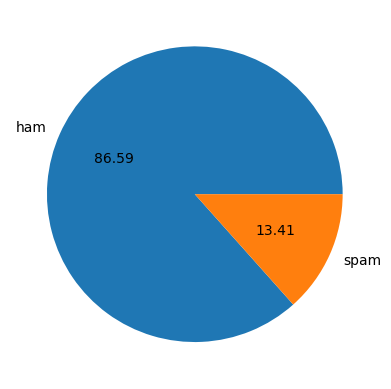

In [8]:
plt.pie(df["label"].value_counts(),autopct = "%.2f", labels=['ham','spam'])
plt.show()

In [9]:
df["label"].value_counts()

ham     4825
spam     747
Name: label, dtype: int64

In [12]:
df.isnull().sum()

label      0
message    0
dtype: int64

In [13]:
df.dtypes

label      object
message    object
dtype: object

In [14]:
df["clean_message"] = df["message"].apply(lambda x: x.lower())

In [15]:
!pip install contractions

In [16]:
import contractions
import string
import re
import nltk

In [17]:
df["clean_message"] = df["clean_message"].apply(lambda x: contractions.fix(x))

In [18]:
def remove_punct(text):
    """
        Remove the punctuation
    """
#     return re.sub(r'[]!"$%&\'()*+,./:;=#@?[\\^_`{|}~-]+', "", text)
    return text.translate(str.maketrans('', '', string.punctuation))

In [19]:
df["clean_message"] = df["clean_message"].apply(lambda x: remove_punct(x))

In [20]:
#remove numeric from new_text column
def remove_numeric(column,df):
    df[column] = df[column].str.replace('\d+', '')
    return df

In [21]:
df = remove_numeric('clean_message',df)

/tmp/ipykernel_878/3156796766.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df[column] = df[column].str.replace('\d+', '')


In [22]:
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec
import gensim.downloader as api

In [23]:
df['clean_message'] = df['clean_message'].apply(lambda text: word_tokenize(str(text)))

In [24]:
# Removing stopwords.
nltk.download("stopwords")
from nltk.corpus import stopwords

stop = set(stopwords.words('english'))
df['clean_message'] = df['clean_message'].apply(lambda x: [word for word in x if word not in stop])

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [25]:
from nltk.stem import PorterStemmer

def porter_stemmer(text):
    """
        Stem words in list of tokenized words with PorterStemmer
    """
    stemmer = nltk.PorterStemmer()
    stems = [stemmer.stem(i) for i in text]
    return stems

In [26]:
df['clean_message'] = df['clean_message'].apply(lambda x: porter_stemmer(x))
df.head(3)

,label,message,clean_message
0,ham,"Go until jurong point, crazy.. Available only ...","[go, jurong, point, crazi, avail, bugi, n, gre..."
1,ham,Ok lar... Joking wif u oni...,"[ok, lar, joke, wif, oni]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,"[free, entri, wkli, comp, win, fa, cup, final,..."


In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
from collections import  Counter

In [28]:
df['clean_message'] = df['clean_message'].apply(lambda tokens: ' '.join(tokens))

In [29]:
df.head(3)

,label,message,clean_message
0,ham,"Go until jurong point, crazy.. Available only ...",go jurong point crazi avail bugi n great world...
1,ham,Ok lar... Joking wif u oni...,ok lar joke wif oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entri wkli comp win fa cup final tkt st m...


# TFIDF Vectorizer 

In [32]:
# Initilizing TFIDF Vectorizer
tfidv = TfidfVectorizer(max_features=3000)

In [33]:
X = tfidv.fit_transform(df["clean_message"]).toarray()

In [34]:
y = df["label"].values

In [35]:
# Performing Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=2)

In [36]:
# Importing the required preprocessing libraries:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder

In [37]:
#label encoding for lable (y) variable:
le = LabelEncoder()

le.fit(y_train)

y_train = le.transform(y_train)
y_test = le.transform(y_test)

In [38]:
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, confusion_matrix

# SVC

In [39]:
svc = SVC()
svc.fit(X_train, y_train)

y_pred = svc.predict(X_test)
auc = np.round(roc_auc_score(y_test, y_pred), 3)
print(f"Test ROC AUC: {auc}\n")
print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}")

Test ROC AUC: 0.895

Confusion Matrix:
[[955   2]
 [ 33 125]]


In [40]:
from sklearn.naive_bayes import GaussianNB,MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier, XGBRFClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score

In [41]:
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.968609865470852

In [42]:
precision = precision_score(y_test, y_pred)
precision

0.984251968503937

# LogisticRegression

In [43]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C=90, max_iter=100,penalty='l2')

In [44]:
lr.fit(X_train, y_train)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=90)

In [45]:
y_pred_lr = lr.predict(X_test)
auc = np.round(roc_auc_score(y_test, y_pred_lr), 3)

In [46]:
print(f"Test ROC AUC: {auc}\n")
print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred_lr)}")

Test ROC AUC: 0.919

Confusion Matrix:
[[954   3]
 [ 25 133]]


In [47]:
accuracy = accuracy_score(y_test, y_pred_lr)
accuracy

0.9748878923766816

In [48]:
precision = precision_score(y_test, y_pred_lr)
precision

0.9779411764705882

# Naive Bayes classifier

In [49]:
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB().fit(X_train, y_train)

In [50]:
y_pred_nb = model.predict(X_test)
auc = np.round(roc_auc_score(y_test, y_pred_nb), 3)

In [51]:
print(f"Test ROC AUC: {auc}\n")
print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred_nb)}")

Test ROC AUC: 0.88

Confusion Matrix:
[[957   0]
 [ 38 120]]


In [52]:
accuracy = accuracy_score(y_test, y_pred_nb)
accuracy

0.9659192825112107

In [53]:
precision = precision_score(y_test, y_pred_nb)
precision

1.0

**Naive Bayes classifier got good results**